<a href="https://colab.research.google.com/github/eunzizizip/2025_BigData_FireWeather/blob/main/FireWeather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install -y fonts-nanum
!rm -rf ~/.cache/matplotlib


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:13 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran4

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

font_paths = [f for f in fm.findSystemFonts() if 'NanumGothic' in f]

for f in font_paths:
    fm.fontManager.addfont(f)

mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

#한글 폰트가 잘 불러와지는지....
print("사용 중인 폰트:", mpl.rcParams['font.family'])


사용 중인 폰트: ['NanumGothic']


In [2]:

# 1) Fire(화재 기록) 데이터 전처리

fire = pd.read_csv('/content/drive/MyDrive/fire_data.csv', encoding='cp949')

drop_cols = [
    '화재유형', '발화요인대분류', '발화요인소분류',
    '인명피해(명)소계', '사망', '부상',
    '재산피해소계', '부동산', '동산',
    '장소대분류', '장소중분류', '장소소분류'
]

fire_clean = fire.drop(columns=drop_cols)

# 날짜 처리
fire_clean['화재발생년원일'] = pd.to_datetime(fire_clean['화재발생년원일'])
fire_clean['년'] = fire_clean['화재발생년원일'].dt.year
fire_clean['월'] = fire_clean['화재발생년원일'].dt.month
fire_clean['일'] = fire_clean['화재발생년원일'].dt.day
fire_clean['요일'] = fire_clean['화재발생년원일'].dt.day_name()

# 지역 생성
fire_clean['지역'] = fire_clean['시도'] + ' ' + fire_clean['시군구']

# 필요한 컬럼만 선택하기
fire_clean = fire_clean[['화재발생년원일','년','월','일','요일','지역']]

# 날짜 + 지역별 화재 건수 집계
fire_daily = fire_clean.groupby(
    ['화재발생년원일','년','월','일','요일','지역']
).size().reset_index(name='화재건수')

# 날짜(date)만 따로 생성
fire_daily['날짜'] = fire_daily['화재발생년원일'].dt.date
fire_daily = fire_daily.drop(columns=['화재발생년원일'])

# 시단위 지역 추출
fire_daily['시단위지역'] = fire_daily['지역'].str.split().str[0]

fire_daily.head()


,년,월,일,요일,지역,화재건수,날짜,시단위지역
0,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도
1,2020,1,1,Wednesday,서울특별시 성북구,1,2020-01-01,서울특별시
2,2020,1,1,Wednesday,경상북도 영덕군,1,2020-01-01,경상북도
3,2020,1,1,Wednesday,충청북도 옥천군,1,2020-01-01,충청북도
4,2020,1,1,Wednesday,부산광역시 금정구,1,2020-01-01,부산광역시


In [3]:

# 2) Weather(기상청 날씨 기록) 데이터 전처리

weather = pd.read_csv('/content/drive/MyDrive/weather_data.xls', sep='\t', encoding='cp949')

weather = weather.rename(columns={
    '일시': 'date',
    '평균기온(°C)': 'temp',
    '일강수량(mm)': 'rain',
    '평균 풍속(m/s)': 'wind',
    '평균 상대습도(%)': 'humidity'
})

weather['date'] = pd.to_datetime(weather['date']).dt.date
weather['rain'] = weather['rain'].fillna(0)


# 3) 지역 매핑 딕셔너리 -> 시단위로

station_to_region = {
    '속초': '강원특별자치도','북춘천': '강원특별자치도','철원': '강원특별자치도',
    '동두천': '경기도','파주': '경기도','대관령': '강원특별자치도',
    '춘천': '강원특별자치도','백령도': '인천광역시','북강릉': '강원특별자치도',
    '강릉': '강원특별자치도','동해': '강원특별자치도','서울': '서울특별시',
    '인천': '인천광역시','원주': '강원특별자치도','울릉도': '경상북도',
    '수원': '경기도','영월': '강원특별자치도','충주': '충청북도',
    '서산': '충청남도','울진': '경상북도','청주': '충청북도',
    '대전': '대전광역시','추풍령': '경상북도','안동': '경상북도',
    '상주': '경상북도','포항': '경상북도','군산': '전북특별자치도',
    '대구': '대구광역시','전주': '전북특별자치도','울산': '울산광역시',
    '창원': '경상남도','광주': '광주광역시','부산': '부산광역시',
    '통영': '경상남도','목포': '전라남도','여수': '전라남도',
    '흑산도': '전라남도','완도': '전라남도','고창': '전북특별자치도',
    '순천': '전라남도','홍성': '충청남도','서청주': '충청북도',
    '제주': '제주특별자치도','고산': '제주특별자치도','성산': '제주특별자치도',
    '서귀포': '제주특별자치도','강화': '인천광역시','양평': '경기도',
    '이천': '경기도','인제': '강원특별자치도','홍천': '강원특별자치도',
    '태백': '강원특별자치도','정선군': '강원특별자치도','제천': '충청북도',
    '보은': '충청북도','천안': '충청남도','보령': '충청남도',
    '부여': '충청남도','금산': '충청남도','세종': '세종특별자치시',
    '고창군': '전북특별자치도','영광군': '전라남도','김해시': '경상남도',
    '순창군': '전북특별자치도','북창원': '경상남도','양산시': '경상남도',
    '보성군': '전라남도','강진군': '전라남도','장흥': '전라남도',
    '의령군': '경상남도','함양군': '경상남도','광양시': '전라남도',
    '진도군': '전라남도','봉화': '경상북도','영주': '경상북도',
    '문경': '경상북도','청송군': '경상북도','영덕': '경상북도',
    '의성': '경상북도','구미': '경상북도','영천': '경상북도',
    '경주시': '경상북도','거창': '경상남도','합천': '경상남도',
    '밀양': '경상남도','산청': '경상남도','거제': '경상남도',
    '남해': '경상남도','북부산': '부산광역시',
}

# 매핑 적용
weather['시단위지역'] = weather['지점명'].map(station_to_region)

weather.head()


,지점,지점명,date,temp,rain,wind,humidity,시단위지역
0,90,속초,2018-01-01,1.0,0.0,2.6,21.3,강원특별자치도
1,90,속초,2018-01-02,1.5,0.0,2.9,21.8,강원특별자치도
2,90,속초,2018-01-03,-1.6,0.0,1.6,29.9,강원특별자치도
3,90,속초,2018-01-04,-1.0,0.0,1.5,53.3,강원특별자치도
4,90,속초,2018-01-05,1.5,0.0,1.2,45.4,강원특별자치도


In [4]:

# 4) Fire + Weather 병합

merged = pd.merge(
    fire_daily,
    weather[['date','temp','rain','wind','humidity','시단위지역']],
    left_on=['날짜','시단위지역'],
    right_on=['date','시단위지역'],
    how='left'
)

merged = merged.drop(columns=['date'])

merged.head()


,년,월,일,요일,지역,화재건수,날짜,시단위지역,temp,rain,wind,humidity
0,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.3,0.0,1.0,67.5
1,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.5,0.0,1.2,62.3
2,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.4,0.0,1.9,70.1
3,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.8,0.0,1.0,65.9
4,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-3.0,0.0,1.3,75.0


In [5]:
#잘 병합됐는지 확인하기

merged.info()
merged.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966578 entries, 0 to 966577
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   년         966578 non-null  int32  
 1   월         966578 non-null  int32  
 2   일         966578 non-null  int32  
 3   요일        966578 non-null  object 
 4   지역        966578 non-null  object 
 5   화재건수      966578 non-null  int64  
 6   날짜        966578 non-null  object 
 7   시단위지역     966578 non-null  object 
 8   temp      928217 non-null  float64
 9   rain      928968 non-null  float64
 10  wind      928214 non-null  float64
 11  humidity  927726 non-null  float64
dtypes: float64(4), int32(3), int64(1), object(4)
memory usage: 77.4+ MB


,년,월,일,요일,지역,화재건수,날짜,시단위지역,temp,rain,wind,humidity
0,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.3,0.0,1.0,67.5
1,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.5,0.0,1.2,62.3
2,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.4,0.0,1.9,70.1
3,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-0.8,0.0,1.0,65.9
4,2020,1,1,Wednesday,전북특별자치도 익산시,1,2020-01-01,전북특별자치도,-3.0,0.0,1.3,75.0
5,2020,1,1,Wednesday,서울특별시 성북구,1,2020-01-01,서울특별시,-2.2,0.1,0.6,64.4
6,2020,1,1,Wednesday,경상북도 영덕군,1,2020-01-01,경상북도,2.1,0.0,1.8,56.4
7,2020,1,1,Wednesday,경상북도 영덕군,1,2020-01-01,경상북도,1.4,0.0,3.4,44.6
8,2020,1,1,Wednesday,경상북도 영덕군,1,2020-01-01,경상북도,-1.3,0.0,3.2,57.4
9,2020,1,1,Wednesday,경상북도 영덕군,1,2020-01-01,경상북도,-2.6,0.0,2.1,60.0


시작 날짜를 입력하세요 (예: 2022-01-01): 2023-03-04
종료 날짜를 입력하세요 (예: 2022-12-31): 2024-04-28

분석 기간: 2023-03-04 ~ 2024-04-28
총 화재 건수: 198753건



/tmp/ipython-input-1244413315.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='temp_bin', y='화재건수', ax=ax1,
/tmp/ipython-input-1244413315.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='rain_bin', y='화재건수', ax=ax2,
/tmp/ipython-input-1244413315.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='wind_bin', y='화재건수', ax=ax3,
/tmp/ipython-input-1244413315.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hu

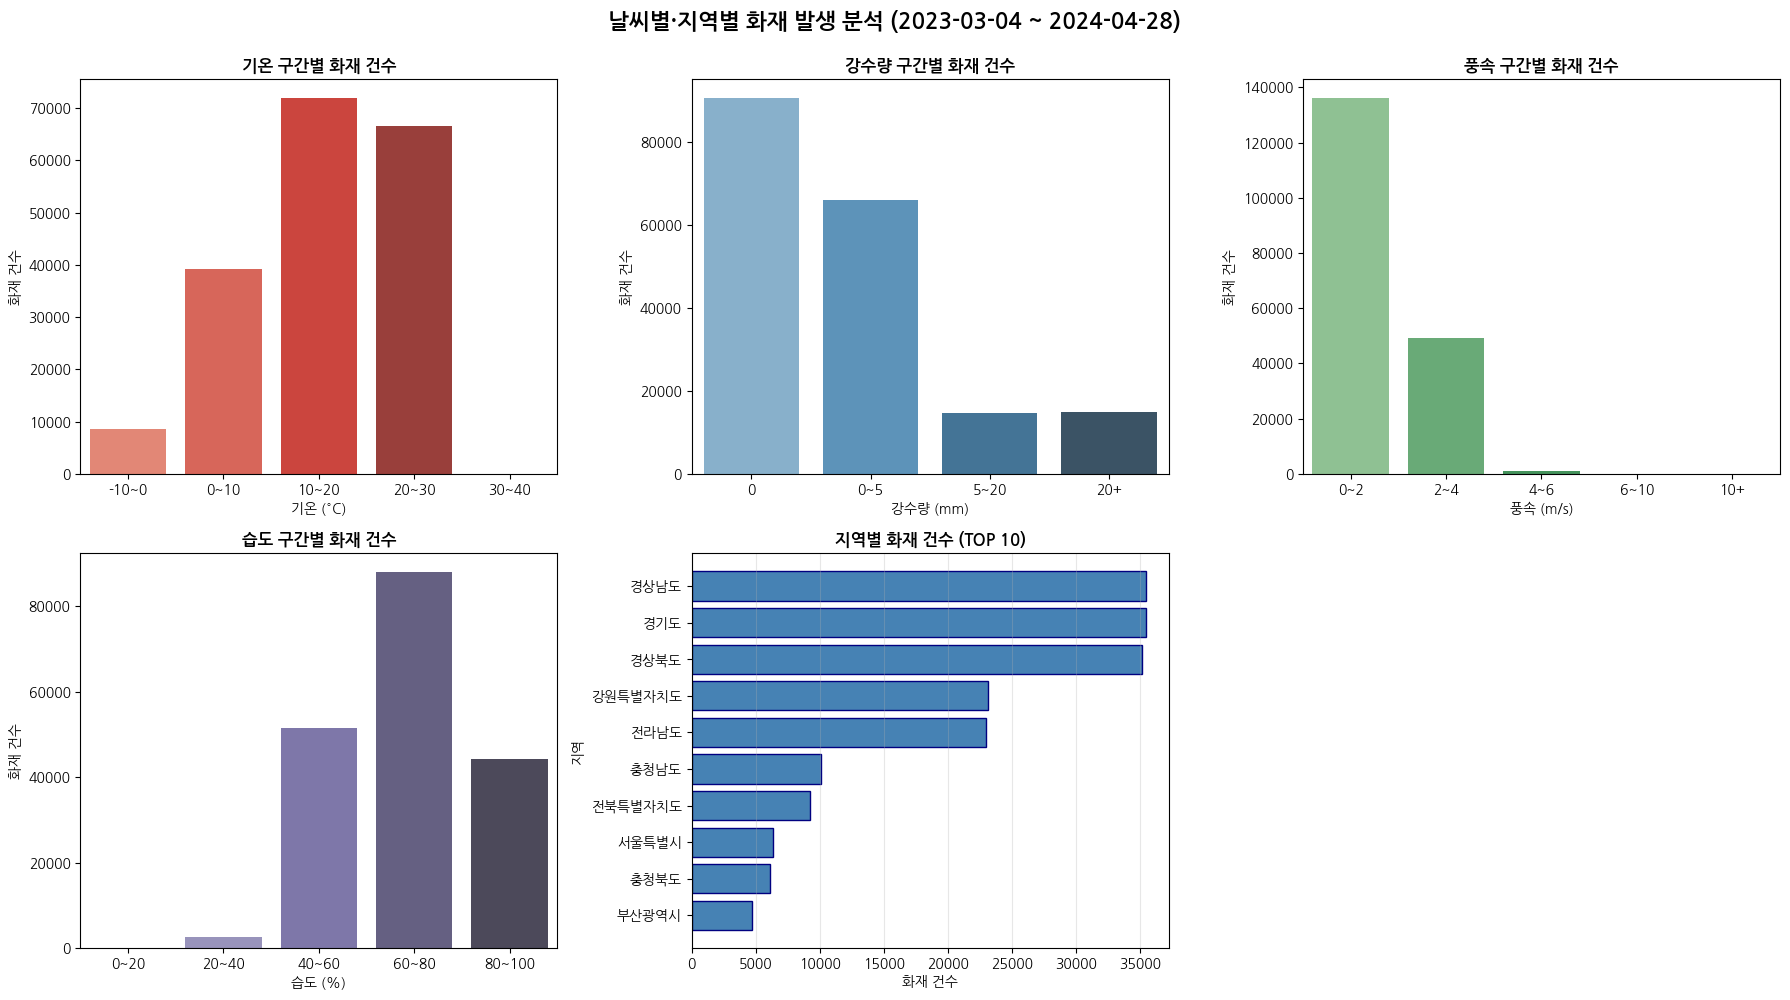

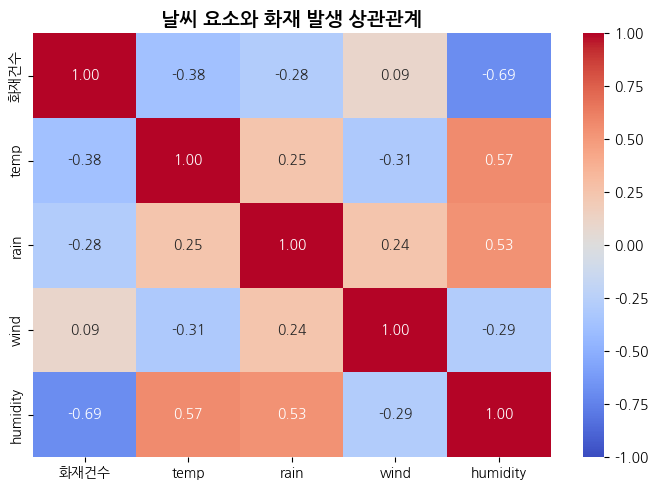

In [10]:


def plot_fire_analysis_input():

    # 1) 사용자 입력
    start_str = input("시작 날짜를 입력하세요 (예: 2022-01-01): ")
    end_str = input("종료 날짜를 입력하세요 (예: 2022-12-31): ")

    try:
        start_date = pd.to_datetime(start_str).date()
        end_date = pd.to_datetime(end_str).date()
    except:
        print("날짜 형식이 잘못되었습니다. YYYY-MM-DD 형태로 입력하세요.")
        return

    if start_date > end_date:
        print("시작 날짜가 종료 날짜보다 늦습니다.")
        return


    # 2) 기간별 데이터 필터링
    df = merged[(merged['날짜'] >= start_date) & (merged['날짜'] <= end_date)].copy()

    if df.empty:
        print("선택한 기간에 데이터가 없습니다.")
        return

    # 날짜별 집계
    df_daily = df.groupby('날짜').agg({
        '화재건수': 'sum',
        'temp': 'mean',
        'rain': 'mean',
        'wind': 'mean',
        'humidity': 'mean'
    }).reset_index()

    print(f"\n분석 기간: {start_date} ~ {end_date}")
    print(f"총 화재 건수: {df_daily['화재건수'].sum():.0f}건\n")


    # 3) 통합 그래프 (2x3 그리드)

    fig = plt.figure(figsize=(18, 10))

    # 기온
    ax1 = plt.subplot(2, 3, 1)
    df2 = df_daily.copy()
    df2['temp_bin'] = pd.cut(df2['temp'], bins=[-10,0,10,20,30,40],
                              labels=['-10~0','0~10','10~20','20~30','30~40'])
    sns.barplot(data=df2, x='temp_bin', y='화재건수', ax=ax1,
                estimator=sum, errorbar=None, palette='Reds_d')
    ax1.set_title('기온 구간별 화재 건수', fontweight='bold', fontsize=12)
    ax1.set_xlabel('기온 (°C)')
    ax1.set_ylabel('화재 건수')

    # 강수량
    ax2 = plt.subplot(2, 3, 2)
    df2['rain_bin'] = pd.cut(df2['rain'], bins=[-0.1,0.1,5,20,200],
                              labels=['0','0~5','5~20','20+'])
    sns.barplot(data=df2, x='rain_bin', y='화재건수', ax=ax2,
                estimator=sum, errorbar=None, palette='Blues_d')
    ax2.set_title('강수량 구간별 화재 건수', fontweight='bold', fontsize=12)
    ax2.set_xlabel('강수량 (mm)')
    ax2.set_ylabel('화재 건수')

    # 풍속
    ax3 = plt.subplot(2, 3, 3)
    df2['wind_bin'] = pd.cut(df2['wind'], bins=[0,2,4,6,10,50],
                              labels=['0~2','2~4','4~6','6~10','10+'])
    sns.barplot(data=df2, x='wind_bin', y='화재건수', ax=ax3,
                estimator=sum, errorbar=None, palette='Greens_d')
    ax3.set_title('풍속 구간별 화재 건수', fontweight='bold', fontsize=12)
    ax3.set_xlabel('풍속 (m/s)')
    ax3.set_ylabel('화재 건수')

    # 습도
    ax4 = plt.subplot(2, 3, 4)
    df2['humidity_bin'] = pd.cut(df2['humidity'], bins=[0,20,40,60,80,100],
                                  labels=['0~20','20~40','40~60','60~80','80~100'])
    sns.barplot(data=df2, x='humidity_bin', y='화재건수', ax=ax4,
                estimator=sum, errorbar=None, palette='Purples_d')
    ax4.set_title('습도 구간별 화재 건수', fontweight='bold', fontsize=12)
    ax4.set_xlabel('습도 (%)')
    ax4.set_ylabel('화재 건수')

    # 지역별 TOP 10
    ax5 = plt.subplot(2, 3, 5)
    df_region = df.groupby('시단위지역')['화재건수'].sum().sort_values(ascending=True).tail(10)
    bars = ax5.barh(df_region.index, df_region.values, color='steelblue', edgecolor='navy')
    ax5.set_title('지역별 화재 건수 (TOP 10)', fontweight='bold', fontsize=12)
    ax5.set_xlabel('화재 건수')
    ax5.set_ylabel('지역')
    ax5.grid(axis='x', alpha=0.3)

    # 빈 공간 없애기
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    plt.suptitle(f'날씨별·지역별 화재 발생 분석 ({start_date} ~ {end_date})',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


    # 4) 날씨 상관관계 히트맵
    weather_cols = ['화재건수','temp','rain','wind','humidity']
    plt.figure(figsize=(7,5))
    sns.heatmap(df_daily[weather_cols].corr(), annot=True, cmap='coolwarm',
                vmin=-1, vmax=1, fmt='.2f')
    plt.title('날씨 요소와 화재 발생 상관관계', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 사용
plot_fire_analysis_input()


In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np


# 1) 필요한 데이터들 정리
df = merged.copy()

# 사용할 컬럼
features = ['년', '월', '일', '지역', 'temp', 'rain', 'wind', 'humidity']
target = '화재건수'

# 지역 인코딩...
le_region = LabelEncoder()
df['지역_encoded'] = le_region.fit_transform(df['지역'])

X = df[['년', '월', '일', '지역_encoded', 'temp', 'rain', 'wind', 'humidity']]
y = df[target]


# 2) Train/Test 나누기

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 3) 회귀 XGBoost 모델

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

# 4) 평가
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)


MSE: 0.00035254305112175643
RMSE: 0.01877612982277648


In [8]:
def predict_fire(date_str, region_str, temp, rain, wind, humidity):


    # 날짜 처리
    date = pd.to_datetime(date_str)
    year, month, day = date.year, date.month, date.day


    # 지역 검증
    if region_str not in le_region.classes_:
        return f" '{region_str}' 는 학습 데이터에 없는 지역입니다. 정확한 지역명을 입력하세요."

    region_encoded = le_region.transform([region_str])[0]


    # 입력값 구성
    input_data = pd.DataFrame([{
        '년': year,
        '월': month,
        '일': day,
        '지역_encoded': region_encoded,
        'temp': temp,
        'rain': rain,
        'wind': wind,
        'humidity': humidity,
    }])


    # 날씨에 따른 화재 건수 예측
    pred = model.predict(input_data)[0]

    return f" 예측된 화재 건수: {pred:.4f} 건"





In [9]:

#--------------------이런 형식으로 입력해야 함---------------------
#date_str: '2024-11-06'
#region_str: '인천광역시 미추홀구'
#temp, rain, wind, humidity: 숫자


print(
    predict_fire(
        date_str='2025-12-20',
        region_str='인천광역시 강화군',
        temp=1,
        rain=0.2,
        wind=4.2,
        humidity=65
    )
)


 예측된 화재 건수: 0.9986 건
